In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
mnist_images = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 275722943.76it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 84473984.54it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 102330305.94it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16008847.70it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5, padding=2)
        self.fc1 = nn.Linear(10 * 7 * 7, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [8]:
def train(model, data, batch_size=64, lr=0.001, num_iters=1000, print_every=100): 
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    n = 0

    while True:
        for imgs, labels in iter(train_loader):
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            n += 1
        
            if n % print_every == 0:
                print("Iter %d. Avg.Loss: %f" % (n, total_loss/print_every))
                total_loss = 0
            if n > num_iters:
                return

In [5]:
fc_model = FCNet()
train(fc_model, mnist_images, num_iters=1000)

Iter 100. Avg.Loss: 1.396088
Iter 200. Avg.Loss: 0.576002
Iter 300. Avg.Loss: 0.462862
Iter 400. Avg.Loss: 0.368582
Iter 500. Avg.Loss: 0.379956
Iter 600. Avg.Loss: 0.333591
Iter 700. Avg.Loss: 0.328005
Iter 800. Avg.Loss: 0.330579
Iter 900. Avg.Loss: 0.275461
Iter 1000. Avg.Loss: 0.220592


In [9]:
cnn_model = FCNet()
train(cnn_model, mnist_images, num_iters=1000)

Iter 100. Avg.Loss: 1.438276
Iter 200. Avg.Loss: 0.576441
Iter 300. Avg.Loss: 0.444493
Iter 400. Avg.Loss: 0.356660
Iter 500. Avg.Loss: 0.361684
Iter 600. Avg.Loss: 0.320380
Iter 700. Avg.Loss: 0.317791
Iter 800. Avg.Loss: 0.313760
Iter 900. Avg.Loss: 0.260767
Iter 1000. Avg.Loss: 0.215894


### Targetted Adversarial Attack
The purpose of an adversarial attack is to perturb an input (usually an image  x) so that a neural network f misclassifies the perturbed image  x+ϵ. In a targeted attack, we want the network f to misclassify the perturbed image into a class of our choosing.

Let's begin with this image. We will perturb the image so our model thinks that the image is of the digit 3, when in fact it is of the digit 5.

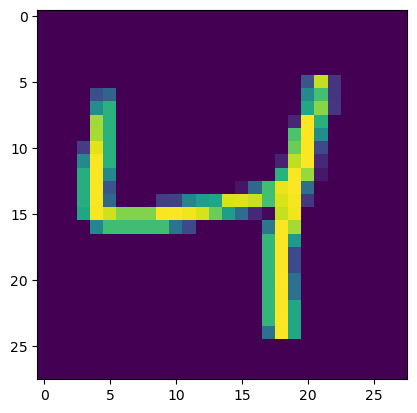

In [27]:
image = mnist_images[2][0]
target_label = 4
model = fc_model

plt.imshow(image[0])

Our approach is as follows:

- We will create a random noise  ϵ that is the same size as the image.
- We will use an optimizer to tune the values of  ϵ to make the neural network misclassify  x+ϵ to our target class

The second step might sound a little mysterious, but is actually very similar to tuning the weights of a neural network!

First, let's create some noise values. In order for PyTorch to be able to tune these values using an optimizer, we need to set requires_grad=True:

In [28]:
noise = torch.randn(1, 28, 28) * 0.01
noise.requires_grad = True

Now, we will tune the noise:

In [29]:
optimizer = optim.Adam([noise], lr=0.01, weight_decay=1)
criterion = nn.CrossEntropyLoss()

for i in range(1000):
    adv_image = torch.clamp(image + noise, 0, 1)
    out = model(adv_image.unsqueeze(0))
    loss = criterion(out, torch.Tensor([target_label]).long())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

To keep the pixel values in noise small, we use a fairly large weight_decay. We use the CrossEntropyLoss, but maximize the neural network prediction of our target_label.

Notice also that the adv_image is clamped so that the pixel values are kept in the range [0, 1].

Now, let's see the resulting image:

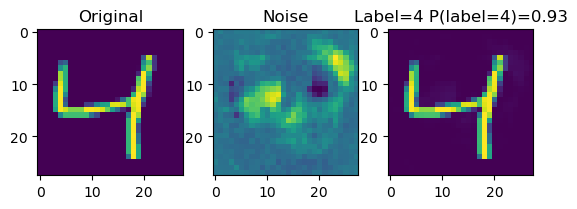

In [30]:
adv_image = torch.clamp(image + noise, 0, 1)
adv_label = torch.argmax(model(adv_image), dim=1).item()
adv_percent = torch.softmax(model(adv_image), dim=1)[0,target_label].item()

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image[0])

plt.subplot(1, 3, 2)
plt.title("Noise")
plt.imshow(noise[0].detach().numpy())

plt.subplot(1, 3, 3)
plt.title("Label=%d P(label=%d)=%.2f" % (adv_label, target_label, adv_percent))
plt.imshow(adv_image.detach().numpy()[0])

We can see that by adding carefully crafted noise that our model outputs a miss-classified image with high confidence.

In [ ]:
def create_adversarial_example(model, image, target_label):
    noise = torch.randn(1, 28, 28)
    noise.requires_grad = True
    
    optimizer = optim.Adam([noise], lr=0.01, weight_decay=1)
    criterion = nn.CrossEntropyLoss()

    for i in range(1000):
        adv_image = torch.clamp(image + noise, 0, 1)
        out = model(adv_image.unsqueeze(0))
        loss = criterion(out, torch.Tensor([target_label]).long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    adv_image = torch.clamp(image + noise, 0, 1)
    adv_label = torch.argmax(model(adv_image), dim=1).item()
    adv_percent = torch.softmax(model(adv_image), dim=1)[0,target_label].item()

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(image[0])
    
    plt.subplot(1, 3, 2)
    plt.title("Noise")
    plt.imshow(noise[0].detach().numpy())
    
    plt.subplot(1, 3, 3)
    plt.title("Label=%d P(label=%d)=%.2f" % (adv_label, target_label, adv_percent))
    plt.imshow(adv_image.detach().numpy()[0])

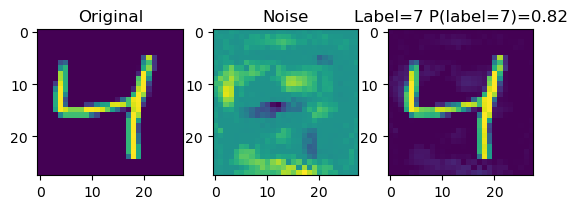

In [31]:
create_adversarial_example(fc_model, mnist_images[2][0], 7)

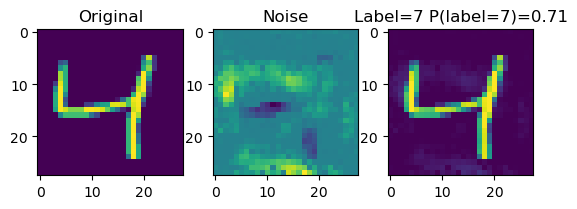

In [32]:
create_adversarial_example(cnn_model, mnist_images[2][0], 7)

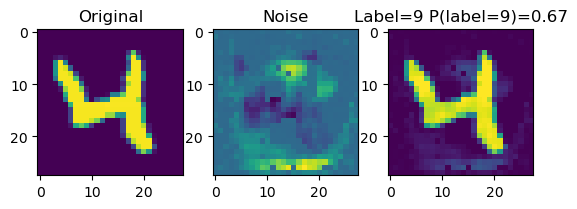

In [24]:
create_adversarial_example(fc_model, mnist_images[20][0], 9)

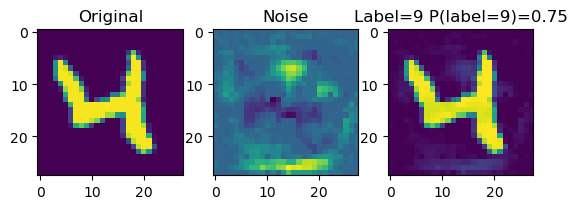

In [25]:
create_adversarial_example(cnn_model, mnist_images[20][0], 9)